<h1>User 235, 250, 252 of 24 lags, 24 pre-step with two feature on LSTM </h1>

<h2>0.Parameters</h2>

In [75]:
import sys ; sys.path.append('../../util') # add utility folder to a system path
from fresh_parameters import parameters

param = parameters(n_repeats=3, 
                   n_data_period = 1, # 0 means 52 wk, 1 means 3 months, 2 means 4 weeks 3 means 1 week and else is 3 days
                   n_lags=24, 
                   n_seq_steps=24, 
                   n_pre_steps=24, n_features=2, 
                   batch_size=168, forcast_batch_size=1,
                   test_size=24 * 7 * 2, 
                   n_epochs=100, 
                   n_neurons=200,
                   b_stateful = False,
                   b_shuffle = True,
                   ratio_rec_dropout = 0.0, # recurrent dropout ratio
                   ratio_input_dropout = 0.2 , # input dropout ratio
                   ratio_validation=0.2,input_folder = "../../input/electricity/",
                   input_file_01 = "elect_235w_id.csv", debug_folder = "../../debug/",
                   b_load_model = False,
                   model_folder = "model_loc/",
                   model_json = "e235_e250_e252_shuffle_True12wk_model.json",
                   model_weight = "e235_e250_e252_shuffle_True_12wk_weight.h5" 
                   )

NEURONS = param.n_neurons

In [76]:
%%javascript
Jupyter.keyboard_manager.command_shortcuts.add_shortcut('r', {
    help : 'run all cells',
    help_index : 'zz',
    handler : function (event) {
        IPython.notebook.execute_all_cells();
        return false;
    }}
);

IPython.keyboard_manager.command_shortcuts.add_shortcut('alt-r',
  function (event) {
      IPython.notebook.kernel.restart();
      setTimeout(function(){ IPython.notebook.execute_all_cells(); }, 1000);
      return false;
});

<IPython.core.display.Javascript object>

In [77]:
import pandas as pd
from fresh_general_util import time_start, time_end, set_seed
start_time = time_start() ; set_seed()

<h2>1. Load an input data and preprocess it</h2>

In [78]:
input_file_01_path = param.input_folder + param.input_file_01
print("input_file_01_path: ",input_file_01_path)

input_file_01_path:  ../../input/electricity/elect_235w_id.csv


In [79]:
from fresh_input_preprocess import load_input_personid, get_sample_period, sample_dataset
def load_input_file(input_file_path, param):
    series_raw = load_input_personid(input_file_path)
    # aggregate electric spendings by hour
    series = series_raw.resample("H").mean() ; #print(series.head())
    start_date, end_date = get_sample_period(param.n_data_period)
    series = sample_dataset(start_date, end_date, series, param.debug_folder, verbose=True)
    print(series.shape)
    return series

In [80]:
# For elect_235
series_01 = load_input_file(input_file_01_path, param)
# elect_250.csv
input_file_02_path = param.input_folder + "elect_250w_id.csv"
series_02 = load_input_file(input_file_02_path, param)
# elect_252.csv
input_file_03_path = param.input_folder + "elect_252w_id.csv"
series_03 = load_input_file(input_file_03_path, param)
import pandas as pd
series = pd.concat([series_01, series_02, series_03])

(2016, 2)
(2016, 2)
(2016, 2)


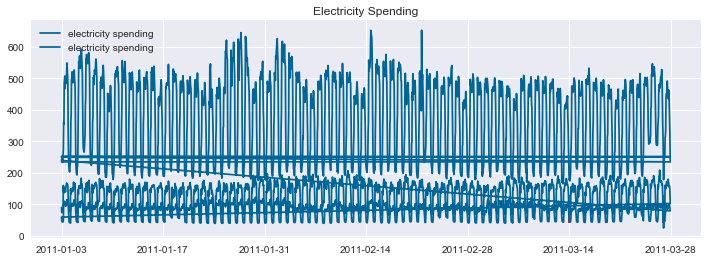

In [81]:
# Show the data set selected
from datetime import date
import matplotlib.pyplot as plt
import seaborn;seaborn.set()
plt.rcParams["figure.figsize"] = [12, 4]
plt.plot(series, label="electricity spending", color = '#006699')
plt.legend(loc='upper left')
plt.title("Electricity Spending")
plt.vlines(x=date(2011,3,14), ymin=40, ymax=130, color='r')
plt.vlines(x=date(2011,3,27), ymin=40, ymax=130, color='r')
plt.show()

<h2>2. Prepare Data using scale abd spliting into train and test</h2>

In [82]:
from numpy import concatenate
import numpy as np
from pandas import concat

from sklearn.preprocessing import MinMaxScaler

In [83]:
import math

In [84]:
from fresh_input_preprocess import prepare_data3, split_X_Y_2, series_to_supervised
# make a train and test data set scaled
scaler, train_scale, val_scale, test_scale = prepare_data3(series, param,verbose=False)

In [85]:
# Split X and Y for Train, Val and Test
x_train_scale, y_train_scale, x_val_scale, y_val_scale, x_test_scale, y_test_scale = split_X_Y_2(train_scale, 
                                                                                                 val_scale, test_scale, 
                                                                                                 param, y_index=2, 
                                                                                                 verbose=False)

<h2>3. Make a model and Experiment</h2>

In [86]:
from fresh_model import display_loss_train, save_model, load_model
from fresh_prediction import fit_lstm2, make_forecasts, forecast_lstm, evaluate_mse, invert_scale, convert_prediction
from fresh_prediction import make_mul_index, predict, predict2
import numpy as np

In [87]:
def train_experiment(param, neurons, scaler, x_train_scale, y_train_scale, x_val_scale, y_val_scale,x_test_scale, 
               y_test_true, verbose=False):
    error_scores = list()
    best_predictions = list()
    best_error_score = 9999.0
    best_history_list = list()

    
    for r in range(param.n_repeats):
        model, train_history_list = fit_lstm2(x_train_scale, y_train_scale, x_val_scale, y_val_scale,neurons, 
                                             param, verbose=verbose)
        old_weights = model.get_weights()                 
        rmse, inv_y_predict, inv_y_true = predict2(old_weights,param, scaler, 
            x_test_scale, y_test_true, verbose=verbose )    
        
        error_scores.append(rmse)
        if best_error_score > rmse:
            best_error_score = rmse
            best_predictions = inv_y_predict
            best_history_list = train_history_list
            best_model = model
    
    if(param.b_load_model == False):
        save_model(best_model, param)
                
    return error_scores, best_error_score, best_predictions, inv_y_true, best_history_list, best_model

In [88]:
import pandas as pd

results = pd.DataFrame()
best_error_score = 9999
best_predictions = list()
best_history_list = list()

for e in [NEURONS] :
    results[str(e)], error_score, predictions, y_test_true, train_history_list, best_model = train_experiment(param, 
                                                                                            e,
                                                                                            scaler,
                                                                                            x_train_scale, 
                                                                                            y_train_scale,
                                                                                            x_val_scale, 
                                                                                            y_val_scale, 
                                                                                            x_test_scale, 
                                                                                            y_test_scale,
                                                                                            verbose=False)
    if best_error_score > error_score:
        best_error_score = error_score
        best_predictions = predictions
        best_history_list = train_history_list
        
print(results.describe())

# of epochs:  0
# of epochs:  10
# of epochs:  20
# of epochs:  30
# of epochs:  40
# of epochs:  50
# of epochs:  60
# of epochs:  70
# of epochs:  80
# of epochs:  90
type predictions: <class 'numpy.ndarray'>
Shape of predictions: 
 (313, 24)
TEST RMSE: 32.734
# of epochs:  0
# of epochs:  10
# of epochs:  20
# of epochs:  30
# of epochs:  40
# of epochs:  50
# of epochs:  60
# of epochs:  70
# of epochs:  80
# of epochs:  90
type predictions: <class 'numpy.ndarray'>
Shape of predictions: 
 (313, 24)
TEST RMSE: 37.219
# of epochs:  0
# of epochs:  10
# of epochs:  20
# of epochs:  30
# of epochs:  40
# of epochs:  50
# of epochs:  60
# of epochs:  70
# of epochs:  80
# of epochs:  90
type predictions: <class 'numpy.ndarray'>
Shape of predictions: 
 (313, 24)
TEST RMSE: 34.755
Saved model to disk
             200
count   3.000000
mean   34.902500
std     2.246426
min    32.733719
25%    33.744123
50%    34.754528
75%    35.986891
max    37.219255


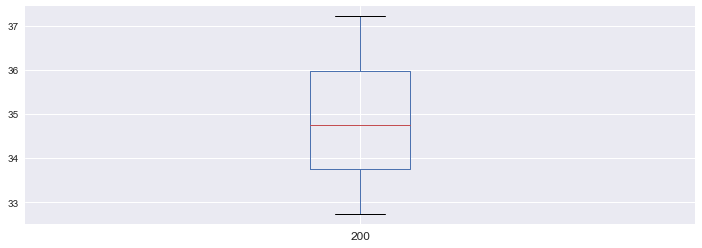

In [89]:
results.boxplot()
plt.show()

<h2>4. Evaluation</h2>

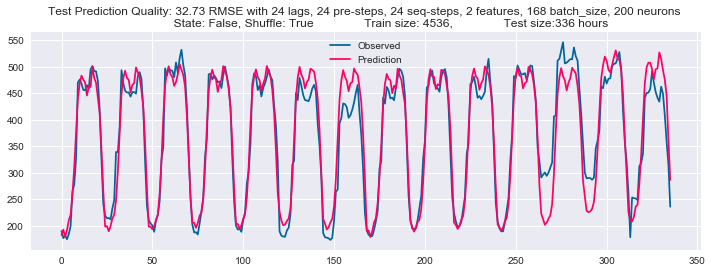

In [90]:
from fresh_prediction import display_obs_pred, evaluate, evaluate_with_model2
display_obs_pred("Test", best_error_score, param, 
                     y_test_true, best_predictions, x_train_scale,TEST_SIZE=param.test_size )    

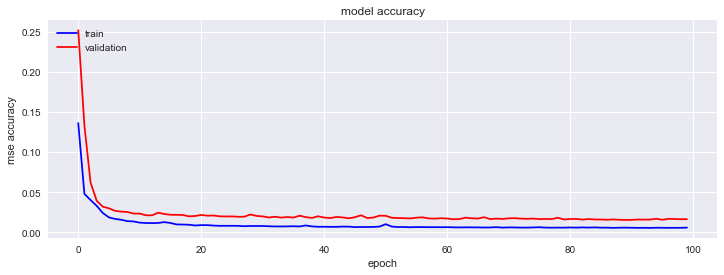

In [91]:
display_loss_train(best_history_list)

type predictions: <class 'numpy.ndarray'>
Shape of predictions: 
 (4536, 24)
TEST RMSE: 29.782


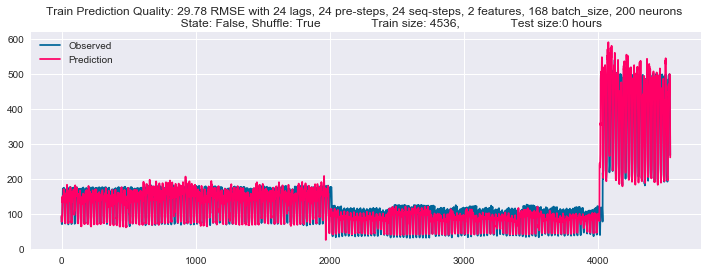

In [92]:
# Evaluate train data    
evaluate_with_model2("Train", best_model, param,scaler,
           x_train_scale, y_train_scale,verbose=False)    
 

type predictions: <class 'numpy.ndarray'>
Shape of predictions: 
 (1008, 24)
TEST RMSE: 41.758


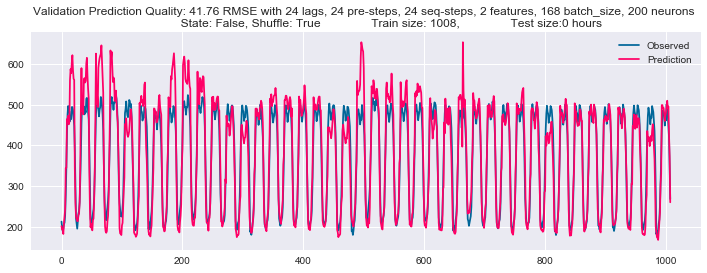

In [93]:
# Evaluate train data    
evaluate_with_model2("Validation", best_model,param,scaler,
           x_val_scale, y_val_scale, verbose=False)   

In [94]:
time_end(start_time)

start time:  1539080225.788672
end time:  1539083921.960191
Total exectution time (Min): 61.602858650684354


<h3>Reference:</h3><br>